# Stat summary to get insights

- Author: Yiran Jing
- Date: 29 Sep

#### Dataset description
1. biom
2. nutr
3. food

DIABBC is a `categorial variable`, the value has different meaning:
- 1: Ever told has diabetes mellitus, still current and long term
- 3: Ever told has diabetes mellitus, not current
- 5: Never told has diabetes mellitus


## Contents
1. Response variable DIABBC(Whether has diabetes mellitus) Visualization
2. Overall view: Heatmap for selected key variables
3. Relationship between SEX, exercise time and HCHOLBC(cholesterol)
4. Relationship between Income level, exercise time and DIABBC
5. Relationship between Age, HCHOLBC(cholesterol) and DIABBC
6. Relationship between DIABBC, DIASTOL and SEX
7. Relationship between DIABBC and INCDEC(Income)
5. Relationship between DIETRDI(Met recommended guidelines ) and DIABBC
8. Relationship between SMSBC(Social marital status of all 15 years+ ppl), BMI, and INCDEC(Income)
8. Relationship betwwen Diet and DIABBC
9. Relationship between Income and Diet
10. Correlation between exercise variables¶



## Key Findings:

1. From heatmap, Only age and cholesterol have relative high relationship with diabetes.
1. **The relationship between sex and Diastolic blood pressure**
    1. On average, the female have lower Diastolic(Diastolic blood pressure) compared to male overall three groups.
2. **The relationship between income and diabetes mellitus**
    1. The group 5 (Never told has diabetes mellitus) have on average high income level
    2. The group 1 (current has diabetes mellitus) generally are from the low-level income group.
3. **The relationship between cholesterol, diabetes, age and exercise time**    
    1. The group with DIABBC = 5 (Never told has diabetes mellitus) generally have longer exercise time compared to others. And the group DIABBC = 5 with HCHOLBC = 5 (never told has high cholesterol) have the longest exercise time. This might indicate that the exercise habits helps to prevent diabetes and high cholesterol.
    1. the group DIABBC = 5 (Never told has diabetes mellitus)with HCHOLBC = 5 (never told has high cholesterol) are yongest on average compared to other groups.
4. **Relationshiop between BMI(body wegiht&hight) and diabetes**
    1. The BMI of the healthy group (DIABBC = 5) is lower than the groups ever told has diabetes mellitus.
5. **Relationship between DIETRDI(Met recommended eating guidelines) and DIABBC**
    1. The group met recommended guidelines have slightly higher rate of no diabetes (95.6%) than the group not met recommended eating guidelines (94.3%)
5. No clear relationship between Social marital status and diabetes.
6. No clear relationship between diet and diabetes

In [1]:
import pandas as pd
import pyspark
from datetime import datetime
import os.path 
import datetime
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from scipy.stats import norm, skew
import statsmodels.api as sm
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

/Users/yiranjing/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/yiranjing/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Load and join dataset

In [2]:
new_tech_biom = pd.read_csv("data/new_tech_biom.csv", encoding = "ISO-8859-1")
new_tech_biom = new_tech_biom.loc[:, ~new_tech_biom.columns.str.contains('^Unnamed')]
tech_nutr = pd.read_csv("data/tech_nutr.csv", encoding = "ISO-8859-1", index_col=False)
tech_nutr = tech_nutr.loc[:, ~tech_nutr.columns.str.contains('^Unnamed')]
tech_food = pd.read_csv("data/tech_food.csv", encoding = "ISO-8859-1", index_col=False )
tech_food =tech_food.loc[:, ~tech_food.columns.str.contains('^Unnamed')]

In [3]:
print("The number of rows in tech_food", len(tech_food))
print("The number of rows in new_tech_biom", len(new_tech_biom))
print("The number of rows in tech_nutr", len(tech_nutr))

The number of rows in tech_food 341897
The number of rows in new_tech_biom 12153
The number of rows in tech_nutr 12153


### Data cleaning
1. For the exercise time, if the exercise time > 1500 mins/week, trade as outlisers, set the value to 0

In [4]:
new_tech_biom["EXLWTBC"] = np.where(new_tech_biom["EXLWTBC"] >1500, 0, new_tech_biom['EXLWTBC'])
new_tech_biom["EXLWVBC"] = np.where(new_tech_biom["EXLWVBC"] >1500, 0, new_tech_biom['EXLWVBC'])
new_tech_biom["EXLWMBC"] = np.where(new_tech_biom["EXLWMBC"] >1500, 0, new_tech_biom['EXLWMBC'])

#### Join thress datasets
The join key:
1. ABSPID(unique person ID)
2. ABSHID(persons household ID)

In [5]:
# join three datasets based on ABSPID(unique person ID), ABSHID(persons household ID), 
merged_food_nutr = pd.merge(tech_nutr, tech_food, on=['ABSPID',"ABSHID"]) # inner join 
merged_food_nutr_binom = pd.merge(merged_food_nutr, new_tech_biom, on=['ABSPID'])

In [6]:
merged_food_nutr_binom.head(2)

,ABSHID,ABSPID,BMR,EIBMR1,EIBMR2,ENERGYT1,ENERGYT2,ENRGYT1,ENRGYT2,MOISTT1,MOISTT2,PROTT1,PROTT2,FATT1,FATT2,CHOWSAT1,CHOWSAT2,CHOWOAT1,CHOWOAT2,STARCHT1,STARCHT2,SUGART1,SUGART2,FIBRET1,FIBRET2,ALCT1,ALCT2,PREVAT1,PREVAT2,PROVAT1,PROVAT2,RETEQT1,RETEQT2,B1T1,B1T2,B2T1,B2T2,B3T1,B3T2,NIACINT1,NIACINT2,FOLATT1,FOLATT2,FOLICT1,FOLICT2,TOTFOLT1,TOTFOLT2,FOLEQT1,FOLEQT2,B6T1,B6T2,B12T1,B12T2,VITCT1,VITCT2,VITET1,VITET2,CALCT1,CALCT2,IODINET1,IODINET2,IRONT1,IRONT2,MAGT1,MAGT2,PHOST1,PHOST2,POTAST1,POTAST2,SELT1,SELT2,SODIUMT1,SODIUMT2,ZINCT1,ZINCT2,CAFFT1,CAFFT2,CHOLT1,CHOLT2,SATFATT1,SATFATT2,MUFATT1,MUFATT2,PUFATT1,PUFATT2,LAT1,LAT2,ALAT1,ALAT2,LCN3T1,LCN3T2,TRANST1,TRANST2,PROPER1,PROPER2,FATPER1,FATPER2,LAPER1,LAPER2,ALAPER1,ALAPER2,CHOPER1,CHOPER2,SUGPER1,SUGPER2,STARPER1,STARPER2,ALCPER1,ALCPER2,SATPER1,SATPER2,TRANPER1,TRANPER2,FIBRPER1,FIBRPER2,MONOPER1,MONOPER2,POLYPER1,POLYPER2,GRAINS1N,WHOLGR1N,REFGRA1N,VEGLEG1N,GREENS1N,VGORSV1N,STARCH1N,LEGVEG1N,OTHVEG1N,FRUIT1N,FRSHF1N,DRFR1N,FRJUIC1N,DAIRY1N,DAIRHF1N,DAIRMF1N,DAIRLF1N,MEAT1N,MEATL1N,MEATLD1N,RDMTL1N,RDMTLU1N,RDMTLP1N,RDMTN1N,RDMTNU1N,RDMTNP1N,PLTYL1N,PLTYLU1N,FISH1N,EGGS1N,LEGMT1N,NUTS1N,WATER1N,UNSAT1N,FRESUG1N,ADDSUG1N,MEATLG1N,MEATDG1N,RDMTLG1N,RDMLUG1N,RDMLPG1N,RDMTNG1N,RDMNUG1N,RDMNPG1N,PLTYLG1N,PLTLUG1N,PLTLPG1N,PLTYNG1N,PLTNUG1N,PLTNPG1N,RDMTTG1N,RDMTUG1N,PLTYTG1N,PLTYUG1N,WATERG1N,WATERG2N,GRAINS2N,VEGLEG2N,FRUIT2N,FRSHF2N,MEAT2N,DAIRY2N,MEATLD2N,MEATL2N,WATER2N,UNSAT2N,FRESUG2N,ADDSUG2N,PEFRESD1,PEADDSD1,PEFRESD2,PEADDSD2,BMR_MISS,EIBMR1_MISS,EIBMR2_MISS,GRAMWGT,FOODCODC,ENERGYWF,ENERGYNF,MOISTURE,PROTEIN,FATG,CHOWSA,CHOWOSA,STARCH,SUGARS,FIBRE,ALCOHOL,PREVITA,PROVITA,RETEQV,B1MG,B2MG,B3MG,NIACINEQ,FOLATEUG,FOLACID,TOTFOL,FOLATEQV,B6MG,B12UG,VITCMG,VITEMG,CALMG,IODINEUG,IRONMG,MAGMG,PHOSMG,POTASMG,SELUG,SODMG,ZINCMG,CAFFMG,CHOLMG,SFAG,MUFAG,PUFAG,LAG,ALAG,LCN3MG,TRANSMG,COMBCODE,EATTIMEC,EATOCC,DAYNUM,TWDIG,THRDIG,FIVDIG,DISCFLG,GRNSRV,WGSRV,...,FRSHFSRV,DRFRSRV,FRJCSRV,DAIRYSRV,HFDASRV,HFCHSSRV,HFPOWSRV,MFDASRV,MFMLKSRV,MFEVPSRV,MFCONSRV,MFCHHSRV,MFCHSSRV,MFYOGSRV,MFALTSRV,MFSNASRV,LFDASRV,LFMLKSRV,LFEVPSRV,LFCONSRV,LFCHHSRV,LFCHSSRV,LFYOGSRV,LFALTSRV,LFSNASRV,LFPOWSRV,MEATSRV,RMTLSRV,RMTLUSRV,RMTLPSRV,RMTNSRV,RMTNUSRV,RMTNPSRV,PLYLSRV,PLYLUSRV,PLYLPSRV,PLYNSRV,PLYNUSRV,PLYNPSRV,FISHSRV,EGGSSRV,LEGMTSRV,LEGBSRV,TOFUSRV,NUTSSRV,WATRSRV,UNSTSRV,UNSTSSRV,UNSTOSRV,NUTFTSRV,GRNGM,WGGM,WGBRGM,WGGNGM,WGOAGM,WGBFGM,WGSVGM,WGCRGM,WGMFGM,WGFLGM,RFGRGM,RFBRGM,RFGNGM,RFOAGM,RFBFGM,RFSVGM,RFCRGM,RFMFGM,RFFLGM,VEGGM,VGGRGM,VGORGM,STARGM,LEGVGGM,OTHVGGM,OWHLVGM,OVGJGM,FRUITGM,FRSHFGM,DRFRGM,FRJCGM,DAIRYGM,HFDAGM,HFCHSGM,HFPOWGM,MFDAGM,MFMLKGM,MFEVPGM,MFCONGM,MFCHHGM,MFCHSGM,MFYOGGM,MFALTGM,MFSNAGM,LFDAGM,LFMLKGM,LFEVPGM,LFCONGM,LFCHHGM,LFCHSGM,LFYOGGM,LFALTGM,LFSNAGM,LFPOWGM,MEATGM,RMTLGM,RMTLUGM,RMTLPGM,RMTNGM,RMTNUGM,RMTNPGM,PLYLGM,PLYLUGM,PLYLPGM,PLYNGM,PLYNUGM,PLYNPGM,FISHGM,EGGSGM,LEGMTGM,LEGBGM,TOFUGM,NUTSGM,WATRGM,UNSTGM,UNSTSGM,UNSTOGM,NUTFTGM,ADDSGGRM,FRESGGRM,MTTLSRV,MTTNSRV,RMTTSRV,RMTTUSRV,PLYTSRV,PLYTUSRV,MTTLGM,MTTNGM,RMTTGM,RMTTUGM,PLYTGM,PLYTUGM,COMBCODE_MISS,EATTIMEC_MISS,EATOCC_MISS,BMISC,AGEC,SMSBC,COBBC,FEMLSBC,PHDKGWBC,PHDCMHBC,EXLWTBC,EXLWMBC,EXLWVBC,PHDCMWBC,SF2SA1QN,INCDEC,DIABBC,HCHOLBC,HSUGBC,HYPBC,ADTOTSE,BDYMSQ04,DIASTOL,DIETQ12,DIETQ14,DIETQ5,DIETQ8,DIETRDI,SABDYMS,SEX,SLPTIME,SMKDAILY,SMKSTAT,SYSTOL,ALTNTR,ALTRESB,APOBNTR,APOBRESB,B12RESB,BIORESPC,CHOLNTR,CHOLRESB,CVDMEDST,DIAHBRSK,FASTSTAD,FOLATREB,GGTNTR,GGTRESB,GLUCFPD,GLUCFREB,HBA1PREB,HDLCHREB,LDLNTR,LDLRESB,TRIGNTR,TRIGRESB,BMISC_MISS,SMSBC_MISS,FEMLSBC_MISS,PHDKGWBC_MISS,PHDCMHBC_MISS,PHDCMWBC_MISS,INCDEC_MISS,ADTOTSE_MISS,BDYMSQ04_MISS,DIASTOL_MISS,DIETQ12_MISS,DIETQ14_MISS,DIETRDI_MISS,SABDYMS_MISS,SLPTIME_MISS,SMKDAILY_MISS,SMKSTAT_MISS,SYSTOL_MISS,ALTNTR_MISS,ALTRESB_MISS,APOBNTR_MISS,APOBRESB_MISS,B12RESB_MISS,BIORESPC_MISS,CHOLNTR_MISS,CHOLRESB_MISS,CVDMEDST_MISS,DIAHBRSK_MISS,FASTSTAD_MISS,FOLATREB_MISS,GGTNTR_MISS,GGTRESB_MISS,GLUCFPD_MISS,GLUCFREB_MISS,HBA1PREB_MISS,HDLCHREB_

In [7]:
print("The number of rows after merge food and nutr", len(merged_food_nutr))
print("The number of rows after merging three dataset", len(merged_food_nutr_binom)) # same as the size of food dataset

The number of rows after merge food and nutr 341897
The number of rows after merging three dataset 341897


## Response variable (DIABBC) Visualization
Since our topic is related to diabetes, I treate `(DIABBC) Whether has diabetes mellitus` as the response 

DIABBC is a `categorial variable`, the value has different meaning:
- 1: Ever told has diabetes mellitus, still current and long term
- 3: Ever told has diabetes mellitus, not current
- 5: Never told has diabetes mellitus

From plot below we can see that the observations in our data mostly are group 5 (11506), quite few observations in group 3. But for the model prediction, focus on group 1 and group 5 might be enough.

### Frequency table for response 

In [8]:
my_tab = pd.crosstab(index=new_tech_biom["DIABBC"],  # Make a crosstab
                              columns="count")      # Name the count column
my_tab

col_0,count
DIABBC,
1,597
3,50
5,11506


## Overall view: Heatmap for selected key variables

Intuitively, I select some important variables for correlation visualization (based on Mingjie's suggestion):
- DIABBC: Whether has diabetes mellitus
- "HCHOLBC"：Whether has high cholesterol
- "AGEC"
- "SEX"
- "BMISC"：Body mass index (BMI)
- PHDCMHBC：Measured height (cm)
- HSUGBC：Whether has high sugar levels in blood/urine
- SMSBC：Social marital status
- PHDKGWBC：Measured weight(kg)
- BDYMSQ04: Whether currently on a diet
- DIETQ12: How often salt is used
- DIETRDI: Whether vegetable and fruit consumption met recommended dietary 
- “EXLWTBC”: Total mins undertaken physical activity in last week
- “INCDEC”: Equivalised income of household: deciles
- DIASTOL: Diastolic blood pressure (mmHg)

In [9]:
selected_col = ["DIABBC", "DIASTOL","HCHOLBC", "AGEC","SEX", "BMISC", "PHDCMHBC", "HSUGBC", "SMSBC", "PHDKGWBC", 
                "BDYMSQ04", "DIETQ12", "DIETRDI", "EXLWTBC", "INCDEC"]

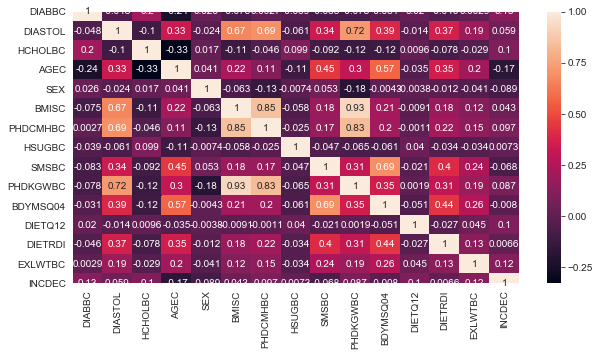

In [10]:
### heatmap on selected columns
corr = new_tech_biom[selected_col].corr()
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,ax=ax)


### Relationship between SEX, exercise time and HCHOLBC
- “EXLWTBC”: Total mins undertaken physical activity in last week
- HCHOLBC：Whether has high cholesterol
- DIABBC: Whether has diabetes mellitus


***
- HCHOLBC = 1: ever told has high cholesterol, still current and long term
- HCHOLBC = 2: ever told has high cholesterol, still current but not long term
- HCHOLBC = 3: ever told has high cholesterol, not current
- HCHOLBC = 5: never told has high cholesterol

From plot below we can see that 
- the distribution of `DIABBC = 1, 2, 3` looks similiar, and the distribution of `DIABBC = 5` looks quite different from others.
- The group with DIABBC = 5 (Never told has diabetes mellitus) generally have longer exercise time compared to others. And the group DIABBC = 5 with HCHOLBC = 5 (never told has high cholesterol) have the longest exercise time. This might indicate that the exercise habits helps to prevent diabetes and high cholesterol.

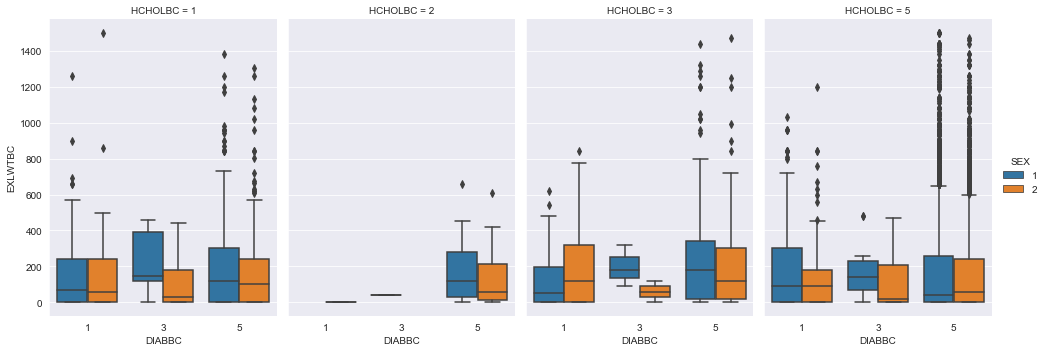

In [11]:
sns.catplot(x="DIABBC", y="EXLWTBC", hue="SEX",
            col="HCHOLBC", aspect=.7,
            kind="box", data=new_tech_biom)

### Relationship between Income level, exercise time and DIABBC

From plot below we can see that:
- for the DIABBC group 5 Never told has diabetes mellitus, the higher income level, the longer exerise time on average. But we cannot find clear parttern when DIABBC = 1 or 3.

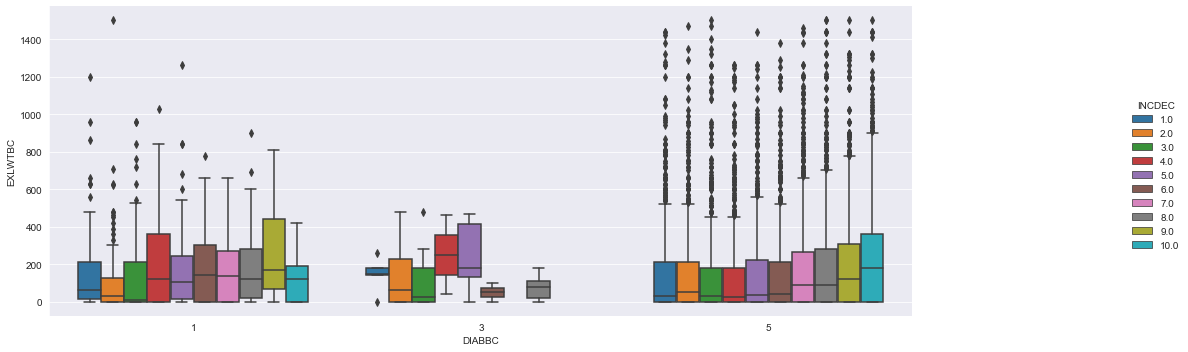

In [12]:
g = sns.catplot(x="DIABBC", y="EXLWTBC", hue="INCDEC",
            aspect=.7,
            kind="box", data=new_tech_biom)
g.fig.set_figwidth(20)
g.fig.set_figheight(5)

From correlation matrix we can see that:
1. age has high corr with Measured weight(kg)
2. Measured weight(kg), hight and BMI are high correlated. 
3. Only age and HCHOLBC have relative high relationship with diabetes. 

### Relationship between Age, HCHOLBC and DIABBC

From plot below, we can see that the group DIABBC = 5 (Never told has diabetes mellitus)with HCHOLBC = 5 (never told has high cholesterol) are yongest age on average compared to other groups.

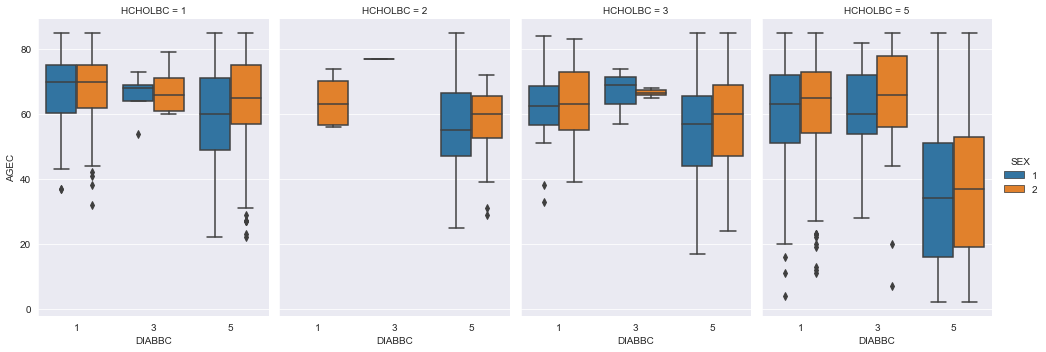

In [13]:
sns.catplot(x="DIABBC", y="AGEC", hue="SEX",
            col="HCHOLBC", aspect=.7,
            kind="box", data=new_tech_biom)

### Relationship between DIABBC, DIASTOL and SEX
`DIASTOL`: Diastolic blood pressure (mmHg)
Valid range 1. to 997
sex 1 = male
sex 2 = female

From The box plot below, we can see that 
1. the distributions of DIASTOL looks quite similar for group 1, group 3 and group 5. 
2. On average, the female have lower Diastolic(Diastolic blood pressure) compared to male overall three groups.
3. There are some outliers in female groups

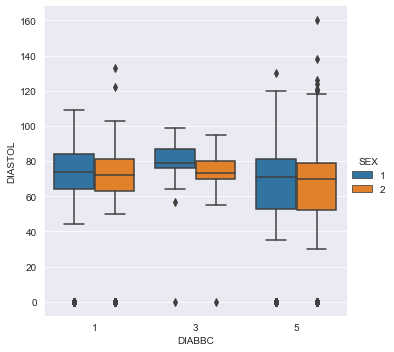

In [14]:
sns.catplot(x="DIABBC", y="DIASTOL", hue="SEX", kind="box", data=new_tech_biom)

### Relationship between DIABBC and INCDEC

- `INCDEC` Equivalised income of household: deciles

- 1	first decile
- 2	second decile
- ...
- 9	ninth decile
- 10 tenth decile

From two plot below, we can see that:
1. The group 5 (Never told has diabetes mellitus) have on average high-level income.
2. The group 1 (current has diabetes mellitus) generally are from the low-level income group.

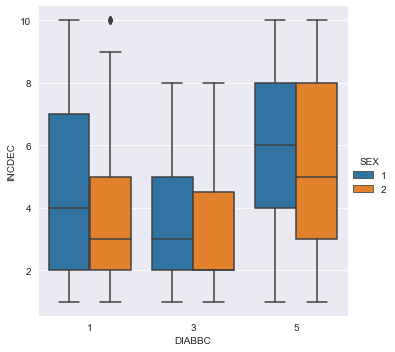

In [15]:
sns.catplot(x="DIABBC", y="INCDEC", hue="SEX", kind="box", data=new_tech_biom)

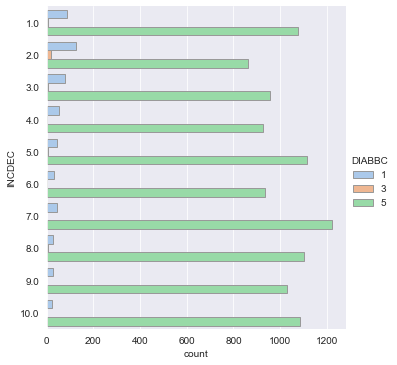

In [16]:
sns.catplot(y="INCDEC", hue="DIABBC", kind="count",
            palette="pastel", edgecolor=".6",
            data=new_tech_biom)

### Relationship between DIETRDI(Whether vegetable and fruit consumption met recommended guidelines	) and DIABBC

- DIETRDI = 0: missing value
- DIETRDI = 1: Met recommended guidelines
- DIETRDI = 2: Did not meet recommended guidelines


From the table below, we can see that:
1. For the group "Met recommended guidelines", there are 95.6% ppl "Never told has diabetes mellitus", 4.1% ppl "Met recommended guidelines"
2. For the group "Did not meet recommended guidelines", there are 94.3% ppl "Never told has diabetes mellitus", 5.2% ppl "Met recommended guidelines"

Thus, There are slight difference comparing the group "Met recommended guidelines or not". 

In [17]:
# Table of survival vs. sex
sub_table = pd.crosstab(index=new_tech_biom["DIETRDI"], 
                           columns=new_tech_biom["DIABBC"],
                           margins=True) # Include row and column totals

sub_table.columns = ["Ever told has diabetes mellitus, still current",
                     "Ever told has diabetes mellitus, not current",
                     "Never told has diabetes mellitus","rowtotal"]

sub_table.index= ["missing value",
                     "Met recommended guidelines",
                     "Did not meet recommended guidelines",
                     "coltotal"]

sub_table

,"Ever told has diabetes mellitus, still current","Ever told has diabetes mellitus, not current",Never told has diabetes mellitus,rowtotal
missing value,0,0,464,464
Met recommended guidelines,45,3,1040,1088
Did not meet recommended guidelines,552,47,10002,10601
coltotal,597,50,11506,12153


In [18]:
sub_table.T/sub_table["rowtotal"]

,missing value,Met recommended guidelines,Did not meet recommended guidelines,coltotal
"Ever told has diabetes mellitus, still current",0.000,0.041,0.052,0.049
"Ever told has diabetes mellitus, not current",0.000,0.003,0.004,0.004
Never told has diabetes mellitus,1.000,0.956,0.943,0.947
rowtotal,1.000,1.000,1.000,1.000


### Relationship between SMSBC(Social marital status of all 15 years+ ppl), BMI, and INCDEC
- SMSBC = 0: missing value (<=15 years ppl)
- SMSBC = 1: Married in a registered marriage
- SMSBC = 2: Married in a de facto marriage	

From plot below we can see that:
1. The BMI of the healthy group (DIABBC = 5) is lower than the groups Ever told has diabetes mellitus.
2. Similar pattern in SMSBC = 1 and SMSBC = 2, and thus, this is no clear relationship between Social marital status and  diabetes.

The Plot of the group whose age > 15, since marital status available for age > 15


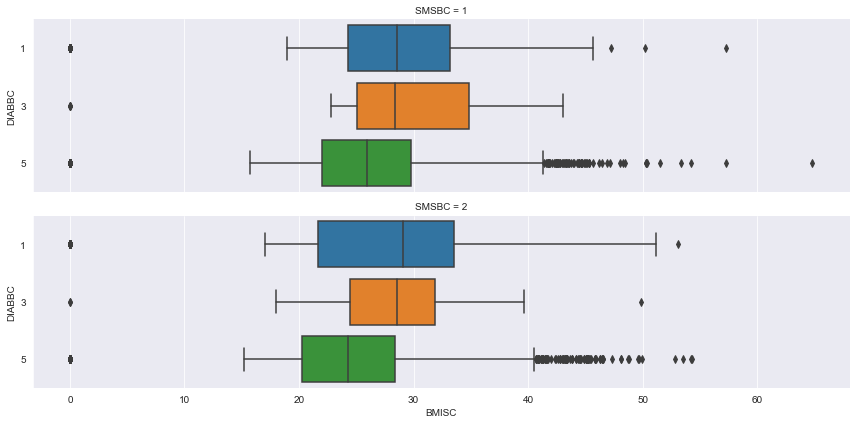

In [19]:
g = sns.catplot(x="BMISC", y="DIABBC", row="SMSBC", kind="box", 
                orient="h", height=3, aspect=4,
                data=new_tech_biom.query("AGEC >= 15"))
#g.set(xscale="log")
print("The Plot of the group whose age > 15, since marital status available for age > 15")

### Relationship betwwen Diet and DIABBC
BDYMSQ04: Whether currently on a diet

- BDYMSQ04 = 0: missing value
- BDYMSQ04 = 1: currently on a diet to lose weight
- BDYMSQ04 = 2: not currently on a diet
- BDYMSQ04 = 3: currently on a diet to lose weight and for health reasons
- BDYMSQ04 = 5: not currently on a diet

From the plot below, we cannot find clear relationship between diet and DIABBC

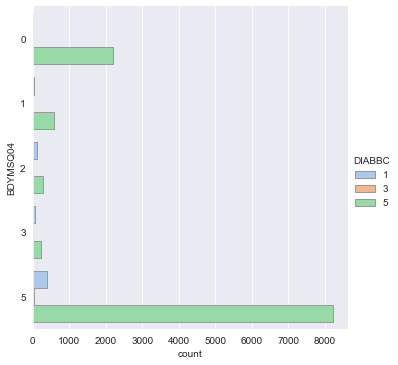

In [20]:
sns.catplot(y="BDYMSQ04", hue="DIABBC", kind="count",
            palette="pastel", edgecolor=".6",
            data=new_tech_biom)

### Relationship between Income and Diet

From plot below, no clear relationship between diet and Income

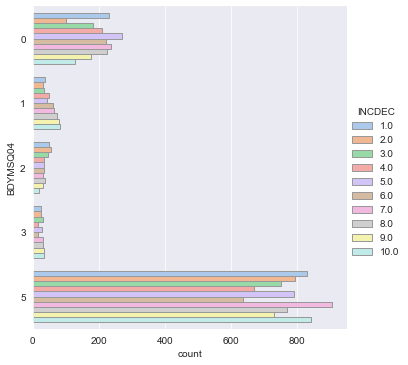

In [21]:
sns.catplot(y="BDYMSQ04", hue="INCDEC", kind="count",
            palette="pastel", edgecolor=".6",
            data=new_tech_biom)

### Correlation between exercise variables
- “EXLWTBC”: Total mins undertaken physical activity in last week
- “EXLWVBC”: Total mins undertaken vigorous physical activity in last week
- “EXLWMBC”: Total mins undertaken medium level activity in last week
- ADTOTSE: Total mins spent sitting or lying down

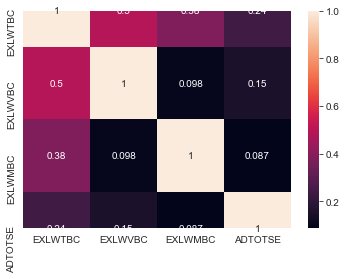

In [22]:
exer_col = ["EXLWTBC", "EXLWVBC", "EXLWMBC", "ADTOTSE"]
corr = new_tech_biom[exer_col].corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)